# Compressing and Representing Information

This notebook is a supplement to the Compressing and Representing Information Chapter of the [Hands-On Generative AI with Transformers and Diffusion Models](https://learning.oreilly.com/library/view/hands-on-generative-ai/9781098149239/) book. This notebooks includes:

* The code from the book
* Additional examples
* Exercise solutions

## AutoEncoders

### Preparing the Data

In [1]:
from datasets import load_dataset

mnist = load_dataset("ylecun/mnist")
mnist

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [2]:
mnist["train"]["image"][1]

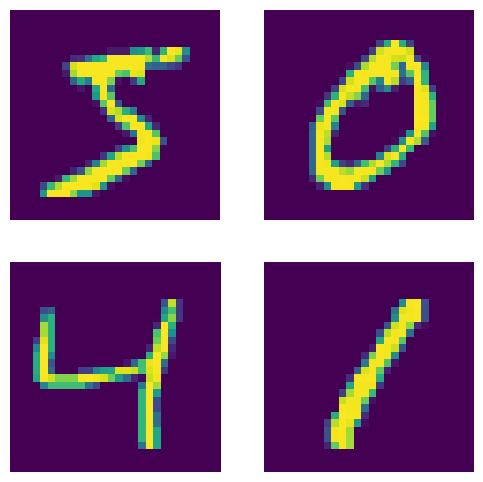

In [3]:
from genaibook.core import show_images

show_images(mnist["train"]["image"][:4])

In [4]:
import matplotlib as mpl

mpl.rcParams["image.cmap"] = "gray_r"

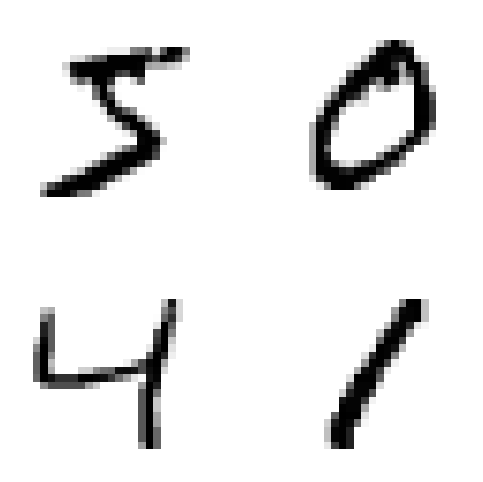

In [5]:
show_images(mnist["train"]["image"][:4])

In [6]:
import torch

torch.manual_seed(1337);

In [7]:
from torchvision import transforms


def mnist_to_tensor(samples):
    t = transforms.ToTensor()
    samples["image"] = [t(image) for image in samples["image"]]
    return samples

In [8]:
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

In [9]:
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

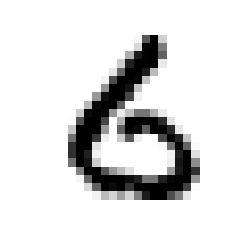

In [10]:
show_images(mnist["train"]["image"][0])

In [11]:
from torch.utils.data import DataLoader

bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

### Modeling the Encoder

In [12]:
from torch import nn


def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [13]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024)
        self.linear = nn.Linear(1024, 16)

    def forward(self, x):
        x = self.conv1(x)  # (batch size, 128, 14, 14)
        x = self.conv2(x)  # (bs, 256, 7, 7)
        x = self.conv3(x)  # (bs, 512, 3, 3)
        x = self.conv4(x)  # (bs, 1024, 1, 1)
        # Keep batch dimension when flattening
        x = self.linear(x.flatten(start_dim=1))  # (bs, 16)
        return x

In [14]:
mnist["train"]["image"][0].shape


torch.Size([1, 28, 28])

In [15]:
in_channels = 1

x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels).eval()

encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [16]:
encoded

tensor([[-0.0145, -0.0318, -0.0109,  0.0080, -0.0218,  0.0305,  0.0183, -0.0294,
          0.0075,  0.0178, -0.0161, -0.0018,  0.0208, -0.0079,  0.0215,  0.0101]],
       grad_fn=<AddmmBackward0>)

In [17]:
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels=1)(batch)
batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

### Modeling the Decoder

In [18]:
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0,
    with_act=True,
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]
    if with_act:  # Controling this will be handy later
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [19]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.linear = nn.Linear(
            16, 1024 * 4 * 4
        )  # note it's reshaped in forward
        self.t_conv1 = conv_transpose_block(1024, 512)
        self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transpose_block(256, out_channels, output_padding=1)

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)  # (bs, 1024*4*4)
        x = x.reshape((bs, 1024, 4, 4))  # (bs, 1024, 4, 4)
        x = self.t_conv1(x)  # (bs, 512, 7, 7)
        x = self.t_conv2(x)  # (bs, 256, 14, 14)
        x = self.t_conv3(x)  # (bs, 1, 28, 28)
        return x

In [20]:
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([64, 1, 28, 28])

### Training

In [21]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder(in_channels)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [23]:
model = AutoEncoder(1)

In [24]:
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [ ]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange

from genaibook.core import get_device

num_epochs = 10
lr = 1e-4

device = get_device()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

losses = []  # List to store the loss values for plotting
for _ in (progress := trange(num_epochs, desc="Training")):
    for _, batch in (
        inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    ):
        batch = batch.to(device)

        # Pass through the model and obtain reconstructed images
        preds = model(batch)

        # Compare the prediction with the original images
        loss = F.mse_loss(preds, batch)

        # Display loss and store for plotting
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

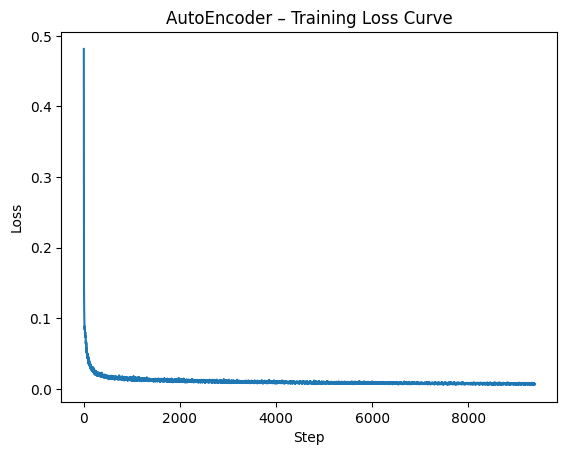

In [26]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

In [27]:
eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

In [28]:
model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = model(eval_batch.to(device)).cpu()

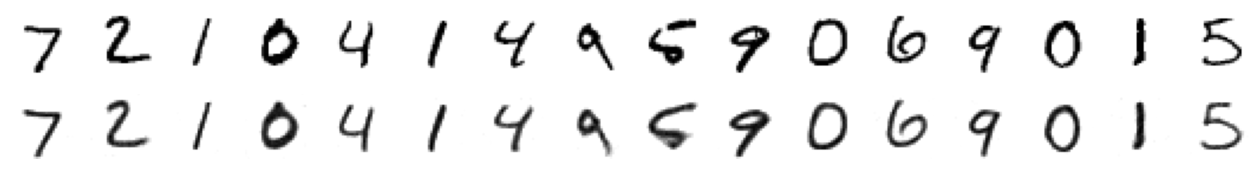

In [29]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

### Exploring the Latent Space


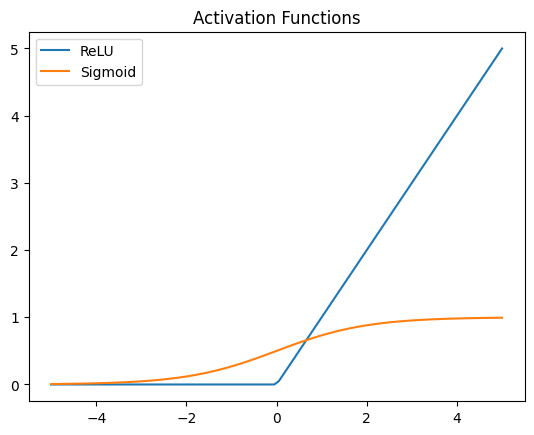

In [30]:
def plot_activation_fn(fn, name):
    x = torch.linspace(-5, 5, 100)
    y = fn(x)
    plt.plot(x, y, label=name)
    plt.legend()


plt.title("Activation Functions")
plot_activation_fn(F.relu, "ReLU")
plot_activation_fn(F.sigmoid, "Sigmoid")

In [31]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )
        self.linear = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = self.linear(x.reshape(bs, -1))
        return x

In [32]:
class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dims):
        super().__init__()

        self.linear = nn.Linear(latent_dims, 1024 * 4 * 4)
        self.t_conv_layers = nn.Sequential(
            conv_transpose_block(1024, 512),
            conv_transpose_block(512, 256, output_padding=1),
            conv_transpose_block(
                256, out_channels, output_padding=1, with_act=False
            ),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))
        x = self.t_conv_layers(x)
        x = self.sigmoid(x)
        return x

In [33]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [34]:
def train(model, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

    model.train()  # Put model in training mode
    losses = []
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model and obtain another set of images
            preds = model(batch)

            # Compare the prediction with the original images
            loss = F.mse_loss(preds, batch)

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())

            # Update the model parameters with the optimizer based on this loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [35]:
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device)

AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

In [ ]:
losses = train(ae_model)

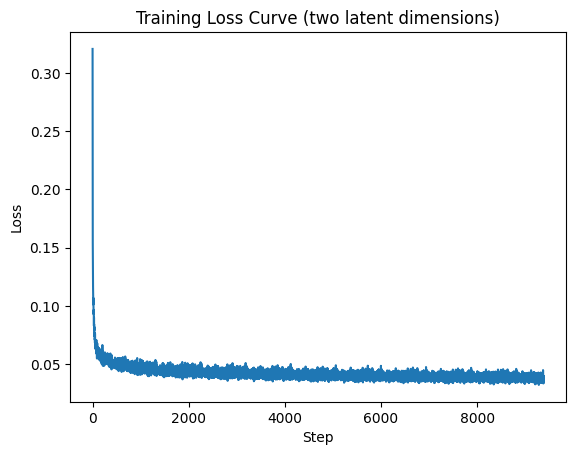

In [37]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimensions)")
plt.show()

In [38]:
ae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model(eval_batch.to(device)).cpu()

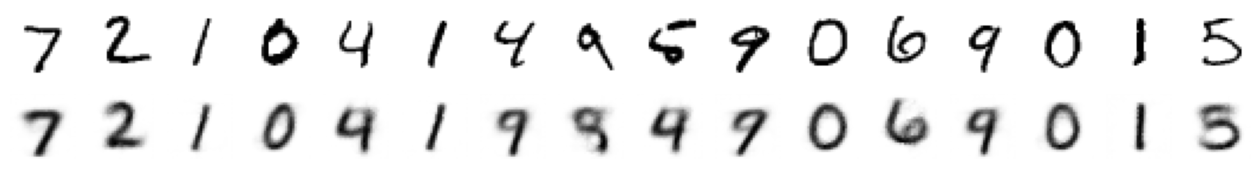

In [39]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

### Visualizing the Latent Space


In [40]:
images_labels_dataloader = DataLoader(mnist["test"], batch_size=512)

In [41]:
import pandas as pd

df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(
    iter(images_labels_dataloader), total=len(images_labels_dataloader)
):
    encoded = ae_model.encode(batch["image"].to(device)).cpu()
    new_items = {
        "x": [t.item() for t in encoded[:, 0]],
        "y": [t.item() for t in encoded[:, 1]],
        "label": batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

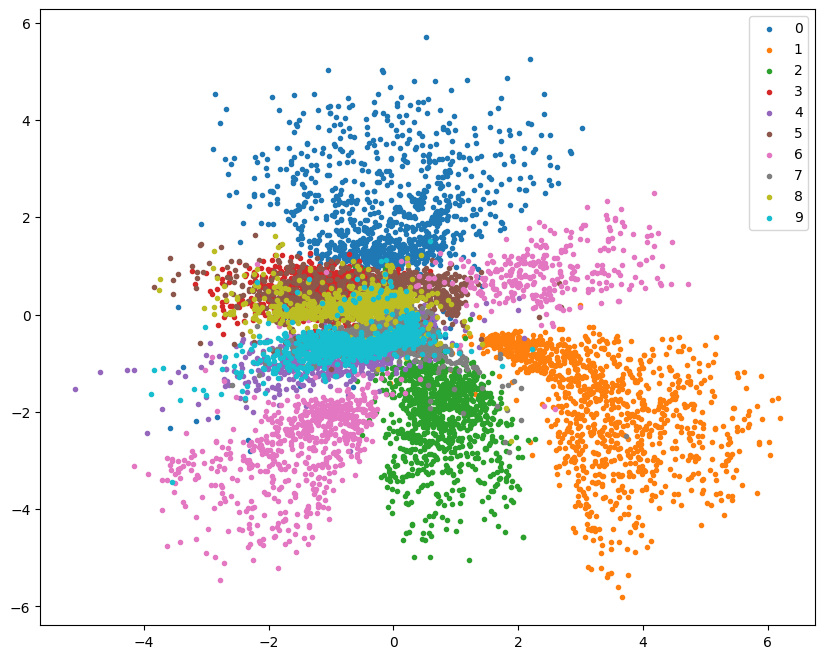

In [42]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

In [43]:
N = 16  # We'll generate 16 points
z = torch.rand((N, 2)) * 8 - 4

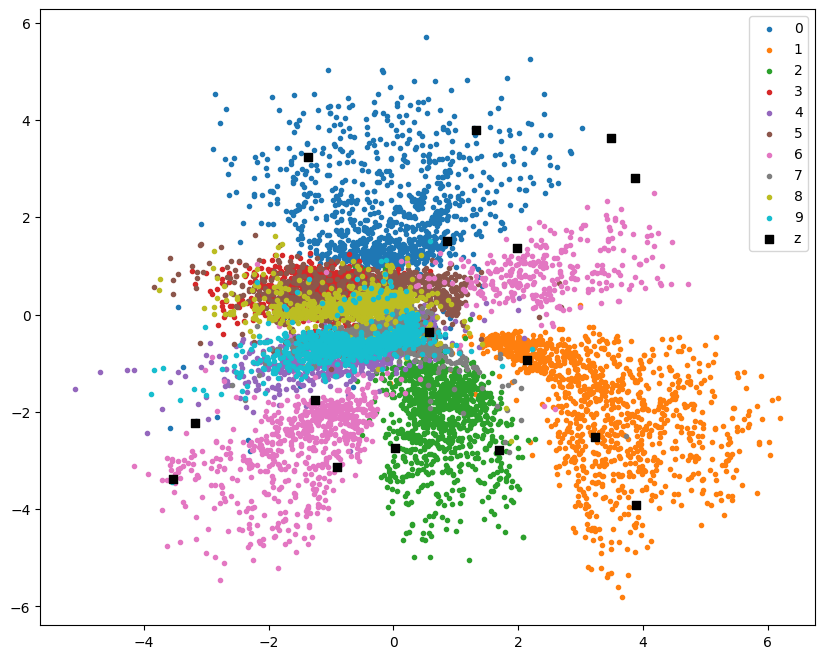

In [44]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.scatter(z[:, 0], z[:, 1], label="z", marker="s", color="black")
plt.legend();

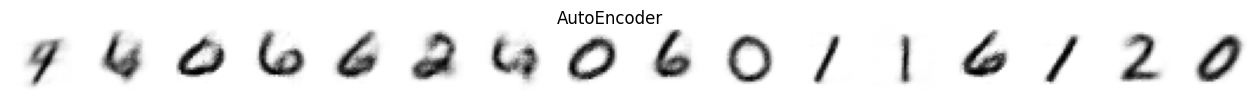

In [45]:
ae_decoded = ae_model.decode(z.to(device))
show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")

## Variational AutoEncoders (VAEs)

### VAE Encoders and Decoders


In [46]:
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )

        # Define fully connected layers for mean and log-variance
        self.mu = nn.Linear(1024, latent_dims)
        self.logvar = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = x.reshape(bs, -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return (mu, logvar)

In [47]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        # Returns mu, log_var
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Obtain parameters of the normal (Gaussian) distribution
        mu, logvar = self.encode(x)

        # Sample from the distribution
        std = torch.exp(0.5 * logvar)
        z = self.sample(mu, std)

        # Decode the latent point to pixel space
        reconstructed = self.decode(z)

        # Return the reconstructed image, and also the mu and logvar
        # so we can compute a distribution loss
        return reconstructed, mu, logvar

    def sample(self, mu, std):
        # Reparametrization trick
        # Sample from N(0, I), translate and scale
        eps = torch.randn_like(std)
        return mu + eps * std

### Training the VAE


In [48]:
def vae_loss(batch, reconstructed, mu, logvar):
    bs = batch.shape[0]

    # Reconstruction loss from the pixels - 1 per image
    reconstruction_loss = F.mse_loss(
        reconstructed.reshape(bs, -1),
        batch.reshape(bs, -1),
        reduction="none",
    ).sum(dim=-1)

    # KL-divergence loss, per input image
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    # Combine both losses and get the mean across images
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

In [49]:
def train_vae(model, num_epochs=10, lr=1e-4):
    model = model.to(device)
    losses = {
        "loss": [],
        "reconstruction_loss": [],
        "kl_loss": [],
    }

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model
            reconstructed, mu, logvar = model(batch)

            # Compute the losses
            loss, reconstruction_loss, kl_loss = vae_loss(
                batch, reconstructed, mu, logvar
            )

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses["loss"].append(loss.item())
            losses["reconstruction_loss"].append(
                reconstruction_loss.mean().item()
            )
            losses["kl_loss"].append(kl_loss.mean().item())

            # Update model parameters based on the total loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [50]:
vae_model = VAE(in_channels=1, latent_dims=2)

In [ ]:
losses = train_vae(vae_model, num_epochs=10, lr=1e-4)

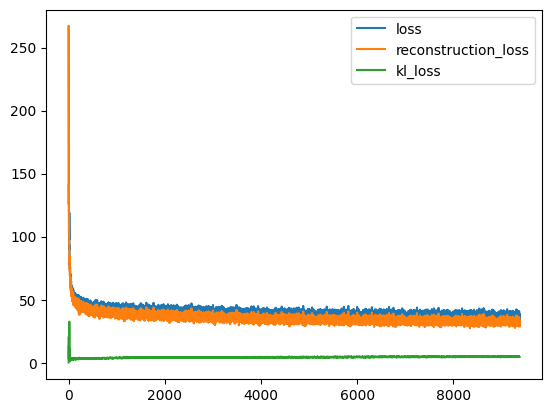

In [52]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend();

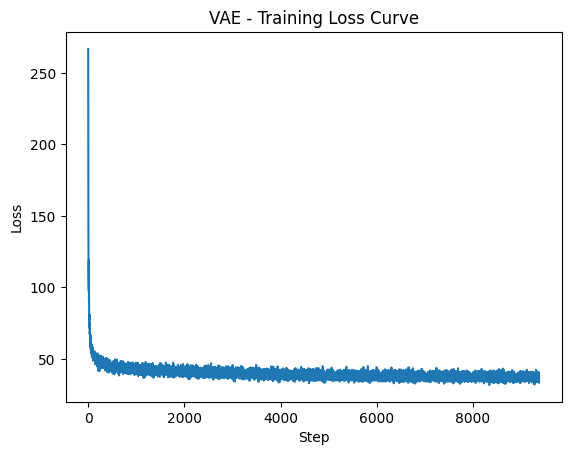

In [53]:
plt.plot(losses["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE - Training Loss Curve")
plt.show()

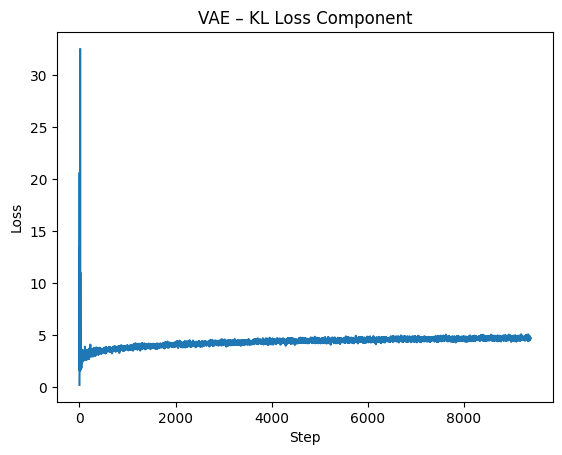

In [54]:
plt.plot(losses["kl_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – KL Loss Component")
plt.show()

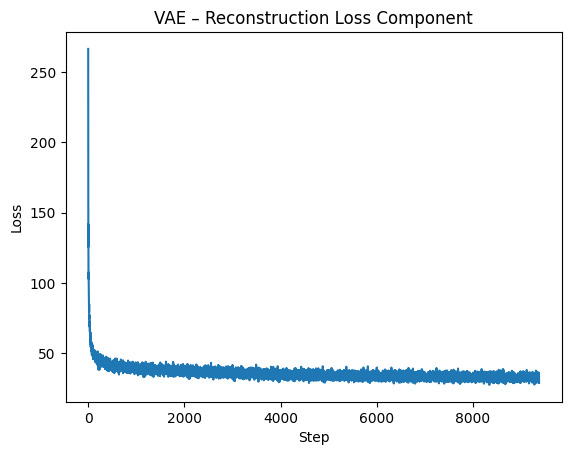

In [55]:
plt.plot(losses["reconstruction_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – Reconstruction Loss Component")
plt.show()

In [57]:
vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))

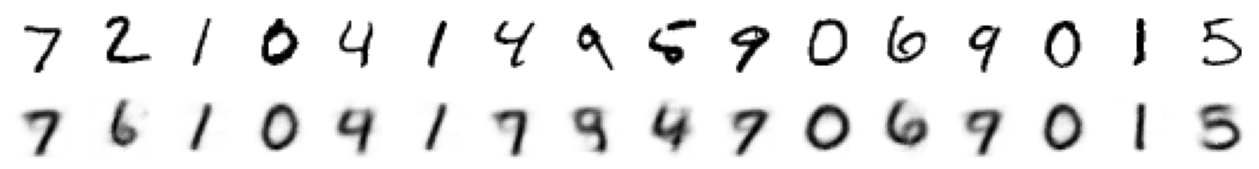

In [58]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

In [ ]:
df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(
    iter(images_labels_dataloader), total=len(images_labels_dataloader)
):
    mu, _ = vae_model.encode(batch["image"].to(device))
    mu = mu.to("cpu")
    new_items = {
        "x": [t.item() for t in mu[:, 0]],
        "y": [t.item() for t in mu[:, 1]],
        "label": batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

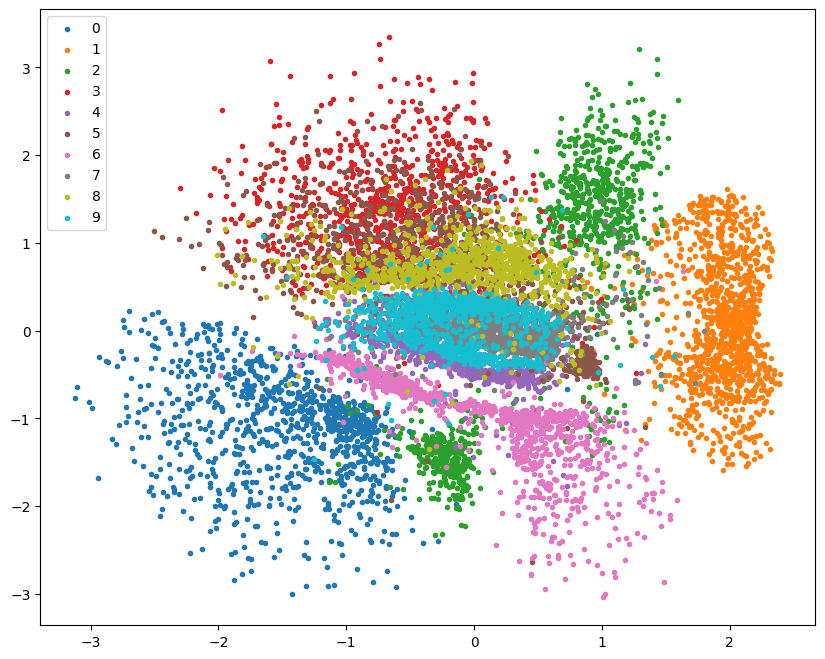

In [60]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

In [61]:
z = torch.normal(0, 1, size=(10, 2))
ae_decoded = ae_model.decode(z.to(device))
vae_decoded = vae_model.decode(z.to(device))

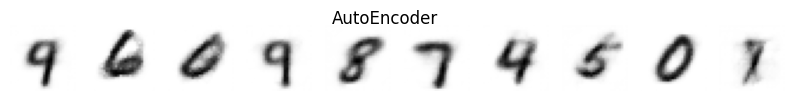

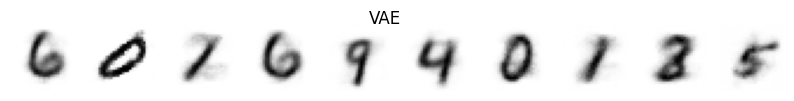

In [62]:
show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")
show_images(vae_decoded.cpu(), imsize=1, nrows=1, suptitle="VAE")

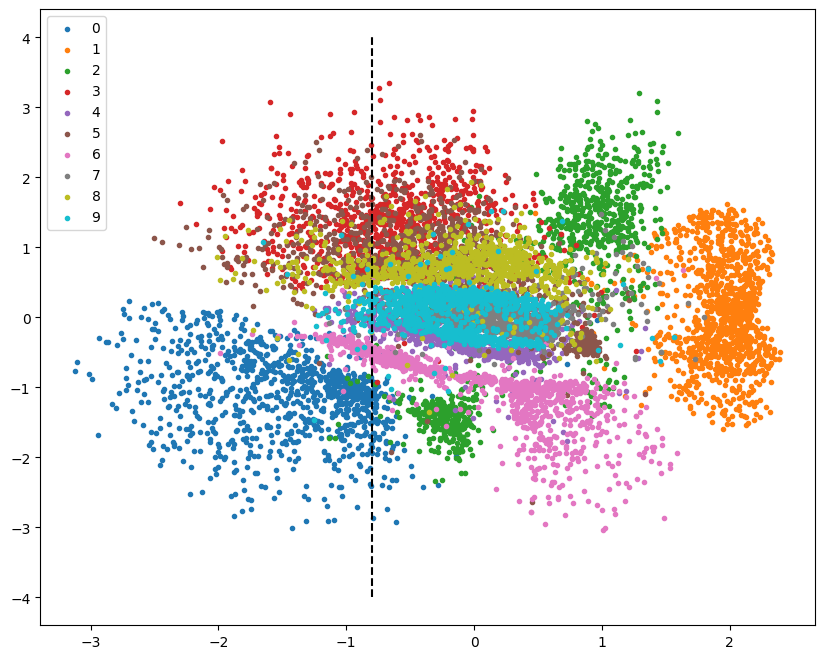

In [63]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.vlines(-0.8, ymin=-4, ymax=4, linestyle="dashed", colors="black")
plt.legend();

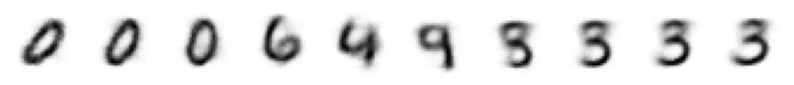

In [64]:
import numpy as np

with torch.inference_mode():
    inputs = []
    for y in np.linspace(-2, 2, 10):
        inputs.append([-0.8, y])
    z = torch.tensor(inputs, dtype=torch.float32).to(device)
    decoded = vae_model.decode(z)
show_images(decoded.cpu(), imsize=1, nrows=1)
     

In [65]:
inputs = []
for x in np.linspace(-2, 2, 20):
    for y in np.linspace(-2, 2, 20):
        inputs.append([x, y])
z = torch.tensor(inputs, dtype=torch.float32).to(device)
decoded = vae_model.to(device).decode(z)

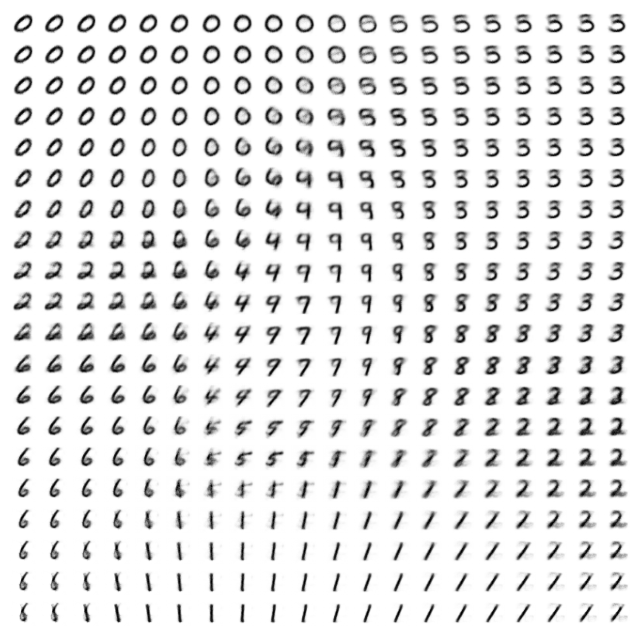

In [66]:
show_images(decoded.cpu(), imsize=0.4, nrows=20)

## CLIP

### Using CLIP, step by step


In [68]:
import requests
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

from genaibook.core import SampleURL

clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

url = SampleURL.LionExample
image = Image.open(requests.get(url, stream=True).raw)

In [72]:
image_inputs = processor(images=image, return_tensors="pt")
pixel_values = image_inputs["pixel_values"]
pixel_values.shape, pixel_values.min(), pixel_values.max()

(torch.Size([1, 3, 224, 224]), tensor(-1.7923), tensor(2.0179))

In [73]:
processor.image_processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

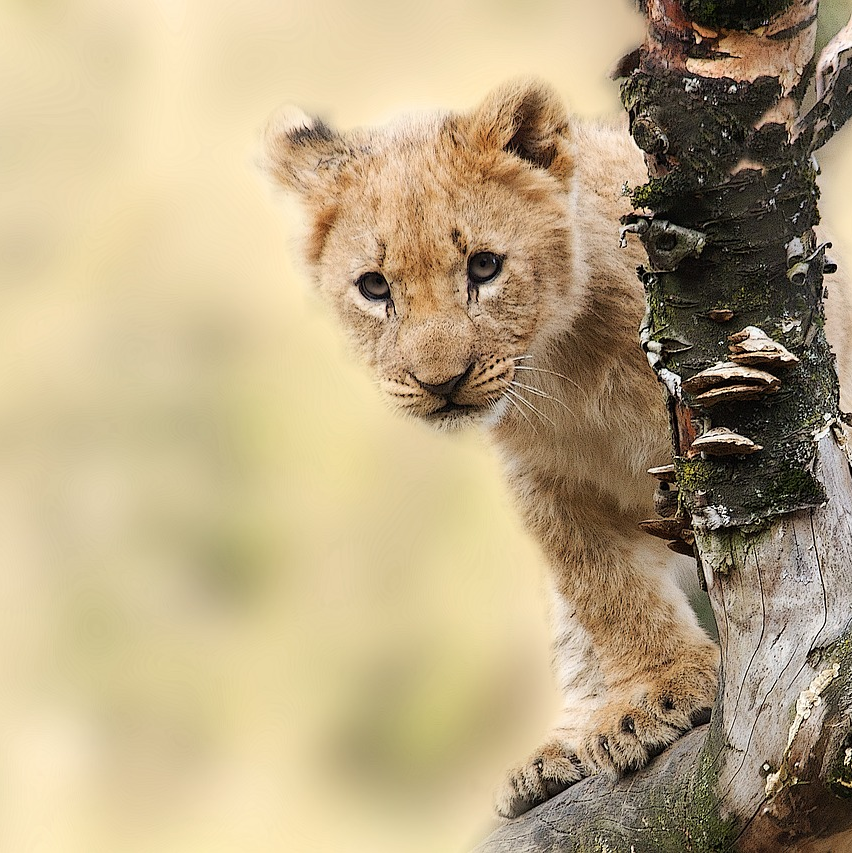

In [74]:
width, height = image.size
crop_length = min(image.size)

left = (width - crop_length) / 2
top = (height - crop_length) / 2
right = (width + crop_length) / 2
bottom = (height + crop_length) / 2

cropped = image.crop((left, top, right, bottom))
cropped

In [75]:
with torch.inference_mode():
    output = clip.vision_model(pixel_values.to(device))
image_embeddings = output.pooler_output
image_embeddings.shape

torch.Size([1, 1024])

In [76]:
prompts = [
    "a photo of a lion",
    "a photo of a zebra",
]

# Padding makes sure all inputs have the same length
text_inputs = processor(text=prompts, return_tensors="pt", padding=True)
text_inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  5567, 49407],
        [49406,   320,  1125,   539,   320, 22548, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}

In [77]:
text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

with torch.inference_mode():
    text_output = clip.text_model(**text_inputs)

In [78]:
text_embeddings = text_output.pooler_output
text_embeddings.shape

torch.Size([2, 768])

In [79]:
print(clip.text_projection)
print(clip.visual_projection)

Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=1024, out_features=768, bias=False)


In [80]:
with torch.inference_mode():
    text_embeddings = clip.text_projection(text_embeddings)
    image_embeddings = clip.visual_projection(image_embeddings)
text_embeddings.shape, image_embeddings.shape

(torch.Size([2, 768]), torch.Size([1, 768]))

In [81]:
text_embeddings = text_embeddings / text_embeddings.norm(
    p=2, dim=-1, keepdim=True
)
image_embeddings = image_embeddings / image_embeddings.norm(
    p=2, dim=-1, keepdim=True
)

In [82]:
similarities = torch.matmul(text_embeddings, image_embeddings.T)
similarities

tensor([[0.2171],
        [0.1888]], device='cuda:0')

In [84]:
similarities = 100 * torch.matmul(text_embeddings, image_embeddings.T)
similarities.softmax(dim=0).cpu()

tensor([[0.9441],
        [0.0559]], device='cuda:0')

### Zero-shot Image Classification with CLIP


In [85]:
clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

image = Image.open(requests.get(SampleURL.LionExample, stream=True).raw)

In [86]:
prompts = [
    "a photo of a lion",
    "a photo of a zebra",
    "a photo of a cat",
    "a photo of an adorable lion cub",
    "a puppy",
    "a lion behind a branch",
]
inputs = processor(
    text=prompts, images=image, return_tensors="pt", padding=True
)
inputs = {k: v.to(device) for k, v in inputs.items()}

outputs = clip(**inputs)
logits_per_image = outputs.logits_per_image
probabilities = logits_per_image.softmax(dim=1)

In [87]:
probabilities = probabilities[0].cpu().detach().tolist()

In [88]:
for prob, prompt in sorted(zip(probabilities, prompts), reverse=True):
    print(f"{100*prob: =2.0f}%: {prompt}")

89%: a photo of an adorable lion cub
 9%: a lion behind a branch
 2%: a photo of a lion
 0%: a photo of a zebra
 0%: a photo of a cat
 0%: a puppy


### Zero-shot Image Classification Pipeline


In [89]:
from transformers import pipeline

classifier = pipeline(
    "zero-shot-image-classification",
    model="openai/clip-vit-large-patch14",
    device=device,
)

In [90]:
scores = classifier(
    image,
    candidate_labels=prompts,
    hypothesis_template="{}",
)

In [91]:
print(scores)

[{'score': 0.8864128589630127, 'label': 'a photo of an adorable lion cub'}, {'score': 0.09321879595518112, 'label': 'a lion behind a branch'}, {'score': 0.01881006360054016, 'label': 'a photo of a lion'}, {'score': 0.0011134877568110824, 'label': 'a photo of a zebra'}, {'score': 0.00041987074655480683, 'label': 'a photo of a cat'}, {'score': 2.491240229574032e-05, 'label': 'a puppy'}]


## Solutions

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the answers before taking a serious stab at it. Scroll down for the answers.

### Exercises

**1. How does generation work if the `AutoEncoder` model is trained with 16 latent dimensions? Can you compare generations between the model with 16 latent dimensions and the one with just 2?**

**2. Train the model again with the same parameters we used (just run the code shown in the chapter) but with different random number initialization, and visualize the latent space. Chances are that the shapes and structure are different. Is this something you would expect? Why?**

**3. How good are the image features extracted by the encoder? Explore it by training a number classifier on top of the encoder.**

**4. When we trained the VAE, we added the reconstruction and KL-divergence losses. However, both have different scales. What will happen if we give more importance to one versus the other? Can you run a few experiments and explain the results?**

**5. The VAE we trained only uses two dimensions to represent the mean and the logvar of the distribution. Can you repeat a similar exploration using 16 dimensions?**

**6. Humans are trained to look at faces and easily identify unrealistic features. Can you try to train an AutoEncoder and a VAE for a dataset containing faces, and see what the results look like? You can start with the [Frey Face dataset](https://cs.nyu.edu/~roweis/data.html) that was used in the VAE paper – it's an homogenous set of monochrome faces from the same person sporting different facial expressions. If you want to be more ambitious, you can try your hand at the [CelebFaces dataset](https://cs.nyu.edu/~roweis/data.html), also hosted on the Hugging Face [Hub](https://huggingface.co/datasets/nielsr/CelebA-faces). Another interesting example could be to try the [Oxford pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), also available on the [Hub](https://huggingface.co/datasets/pcuenq/oxford-pets).**

### Challenge


**7. BLIP-2 for search. The hands-on project on semantic image search is quite challenging, but here's another idea. Can you use the [BLIP-2 model](https://huggingface.co/docs/transformers/main/en/model_doc/blip-2) for similarity tasks, just like we did with CLIP in this chapter? How would you go about it, and how does it compare with CLIP? What other tasks can you solve with BLIP-2?**